In [10]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

RendererRegistry.enable('jupyterlab')

In [11]:
# Suppress warnings.
import warnings
warnings.filterwarnings("ignore")

# Suppress js errors.
alt.renderers.enable('jupyterlab')

In [12]:
DATA_DIR = 'csv/'
IMG_DIR = 'img/'

### Data: Monsoon

In [43]:
monsoon = pd.read_csv(DATA_DIR + 'Monsoon_data.csv', parse_dates=['Date'])
monsoon.set_index('Date', drop=False, inplace=True)

In [42]:
monsoon['dataset'] = 'monsoon'
monsoon['date_str'] = monsoon['Date'].astype(str)
monsoon['year'] = monsoon['date_str'].str[:4]
monsoon['month'] = pd.to_numeric(monsoon['date_str'].str[5:7])

# This could be more elegant.
monsoon.loc[monsoon['month'] <= 12, 'quarter'] = 4
monsoon.loc[monsoon['month'] <= 9, 'quarter'] = 3
monsoon.loc[monsoon['month'] <= 6, 'quarter'] = 2
monsoon.loc[monsoon['month'] <= 3, 'quarter'] = 1

In [41]:
# monsoon.head(20)

### Data: Olou

In [7]:
olou = pd.read_csv(DATA_DIR + 'Olou_counts.csv', parse_dates=['Date'])
olou.set_index('Date', drop=False, inplace=True)

In [28]:
olou['dataset'] = 'olou'
olou['date_str'] = olou['Date'].astype(str)
olou['year'] = olou['date_str'].str[:4]
olou['month'] = pd.to_numeric(olou['date_str'].str[5:7])

# This could be more elegant.
olou.loc[olou['month'] <= 12, 'quarter'] = 4
olou.loc[olou['month'] <= 9, 'quarter'] = 3
olou.loc[olou['month'] <= 6, 'quarter'] = 2
olou.loc[olou['month'] <= 3, 'quarter'] = 1

In [39]:
# olou.head()

### Data: Monsoon + Olou

In [32]:
dataframes = [monsoon, olou]
dataset = pd.concat(dataframes)

In [33]:
dataset.head()

,Date,Precip,date_str,year,month,quarter,dataset,Counts
Date,,,,,,,,
1964-01-01,1964-01-01,1.4,1964-01-01,1964,1,1.0,monsoon,NaN
1964-02-01,1964-02-01,5.7,1964-02-01,1964,2,1.0,monsoon,NaN
1964-03-01,1964-03-01,8.3,1964-03-01,1964,3,1.0,monsoon,NaN
1964-04-01,1964-04-01,24.8,1964-04-01,1964,4,2.0,monsoon,NaN
1964-05-01,1964-05-01,43.7,1964-05-01,1964,5,2.0,monsoon,NaN


### Interactive Visualization

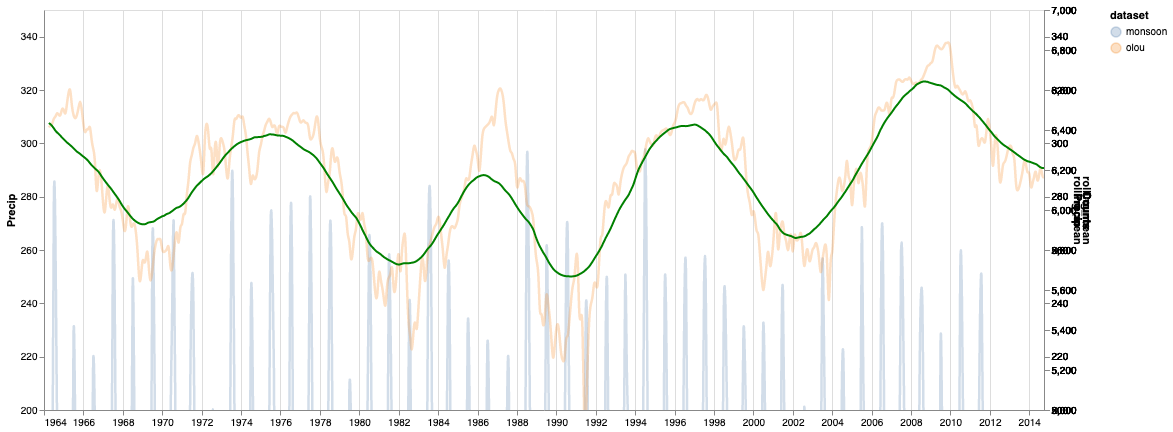

In [384]:
# Pan and zoom
select = alt.selection_interval(
    bind="scales",
    encodings=["x"]
)

# Monsoon precipitation.
line_chart_monsoon = alt.Chart(dataset[np.isnan(dataset['Precip']) == False]).mark_line(
    interpolate='basis',
    strokeWidth=2.5,
    opacity=0.25
).encode(
    x=alt.X('Date:T', title=""),
    y=alt.Y('Precip:Q', scale=alt.Scale(domain=[200, 350])),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
).add_params(
    select
)

# Monsoon precipitation rolling average.
moving_avg_monsoon = alt.Chart(dataset[np.isnan(dataset['Precip']) == False]).transform_window(
    rolling_mean='mean(Precip)',
    frame=[-30, 30],
).mark_line(
    color='red',
    strokeWidth=2,
    interpolate='basis'
).encode(
    x=alt.X('Date:T'),
    y=alt.Y('rolling_mean:Q', scale=alt.Scale(domain=[200, 350]))
)

# Olou cosmic ray counts.
line_chart_olou = alt.Chart(dataset[np.isnan(dataset['Counts']) == False]).mark_line(
    interpolate='basis',
    strokeWidth=2.5,
    opacity=0.25
).encode(
    x=alt.X('Date:T', title=""),
    y=alt.Y('Counts:Q', scale=alt.Scale(domain=[5000, 7000])),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
).add_params(
    select
)

# Olou cosmic ray counts rolling average.
moving_avg_olou = alt.Chart(dataset[np.isnan(dataset['Counts']) == False]).transform_window(
    rolling_mean='mean(Counts)',
    frame=[-30, 30],
).mark_line(
    color='green',
    strokeWidth=2,
    interpolate='basis'
).encode(
    x=alt.X('Date:T'),
    y=alt.Y('rolling_mean:Q', scale=alt.Scale(domain=[5000, 7000]))
)

# Get nearest point y-value from selection.
nearest = alt.selection_point(
    nearest=True,
    on='mouseover',
    fields=['Date'],
    empty=False
)

# Monsoon selector.
selectors_monsoon = alt.Chart(dataset[dataset['dataset'] == 'monsoon']).mark_point().encode(
    x=alt.X('Date:T'),
    y=alt.Y('Precip:Q', scale=alt.Scale(domain=[200, 350])),
    opacity=alt.value(0),
).add_params(
    nearest
)

# Olou selector.
selectors_olou = alt.Chart(dataset[dataset['dataset'] == 'olou']).mark_point().encode(
    x=alt.X('Date:T'),
    y=alt.Y('Counts:Q', scale=alt.Scale(domain=[5000, 7000])),
    opacity=alt.value(0),
).add_params(
    nearest
)

# Monsoon highlighted points.
points_monsoon = alt.Chart(dataset[dataset['dataset'] == 'monsoon']).transform_filter(
    nearest
).mark_point(
    size=90, strokeWidth=1
).encode(
    x=alt.X('Date:T'),
    y=alt.Y('Precip:Q', scale=alt.Scale(domain=[200, 350])),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
)

# Olou highlighted points.
points_olou = alt.Chart(dataset[dataset['dataset'] == 'olou']).transform_filter(
    nearest
).mark_point(
    size=90, strokeWidth=1
).encode(
    x=alt.X('Date:T'),
    y=alt.Y('Counts:Q', scale=alt.Scale(domain=[5000, 7000])),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
)

# Gray draggable bar.
rules = alt.Chart(dataset).mark_rule(
    color='lightgray',
    opacity=0.4
).encode(
    x=alt.X('Date:T'),
    strokeWidth=alt.StrokeWidthValue(4)
).transform_filter(
    nearest
)

# Monsoon label text.
text_monsoon = alt.Chart(dataset[dataset['dataset'] == 'monsoon']).mark_text(
    align='left',
    dx=7,
    fontSize=14
).encode(
    x=alt.X('Date:T'),
    y=alt.X('Precip:Q', scale=alt.Scale(domain=[200, 350])),
    text=alt.Text('Precip', format='.2f'),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
).transform_filter(
    nearest
)

# Olou label text.
text_olou = alt.Chart(dataset[dataset['dataset'] == 'olou']).mark_text(
    align='left',
    dx=7,
    fontSize=14
).encode(
    x=alt.X('Date:T'),
    y=alt.Y('Counts:Q', scale=alt.Scale(domain=[5000, 7000])),
    text=alt.Text('Counts', format='.2f'),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
).transform_filter(
    nearest
)

# Layer the chart.
alt.layer(
    line_chart_monsoon, moving_avg_monsoon, line_chart_olou, moving_avg_olou, points_monsoon, points_olou,
    selectors_monsoon, selectors_olou, rules, text_monsoon, text_olou
).configure_axis(
    # disable=True,
).properties(
    width=1000, height=400
).resolve_scale(x='shared', y='independent')

### Derivative Visualizations

In [318]:
# Zoom and pan.
select = alt.selection_interval(
    bind="scales",
    encodings=["x"]
)

# Single base chart experiment.
base_chart = alt.Chart(dataset).encode(
    alt.X('Date:T')
)

# Monsoon base chart.
# base_chart_monsoon = alt.Chart(dataset[dataset['dataset'] == 'monsoon']).encode(
#     alt.X('Date:T')
# )

# Olou base chart.
# base_chart_olou = alt.Chart(dataset[dataset['dataset'] == 'olou']).encode(
#     alt.X('Date:T')
# )

# Monsoon line chart.
line_chart_monsoon = base_chart_monsoon.mark_line().encode(
    alt.Y('Precip:Q')
).add_params(
    select
)

# Olou line chart.
line_chart_olou = base_chart_olou.mark_circle().encode(
    alt.Y('Counts:Q', scale=alt.Scale(domain=[5000, 7000]))
).add_params(
    select
)

# Nearest datapoint.
nearest = alt.selection_point(
    nearest=True,
    on='mouseover',
    fields=['Date'],
    empty=False
)

# Monsoon selector.
selectors_monsoon = alt.Chart(dataset[dataset['dataset'] == 'monsoon']).mark_point().encode(
    x='Date:T',
    y='Precip:Q',
    opacity=alt.value(0),
).add_params(
    nearest
)

# Olou selector.
selectors_olou = alt.Chart(dataset[dataset['dataset'] == 'olou']).mark_point().encode(
    alt.X('Date:T'),
    alt.Y('Counts:Q', scale=alt.Scale(domain=[5000, 7000])),
    opacity=alt.value(0),
).add_params(
    nearest
)

# Monsoon highlighted points.
points_monsoon = alt.Chart(dataset[dataset['dataset'] == 'monsoon']).transform_filter(
    nearest
).mark_point(
    size=90, strokeWidth=1
).encode(
    alt.X('Date:T'),
    alt.Y('Precip:Q', scale=alt.Scale(domain=[5000, 350])),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
)

# Olou highlighted points.
points_olou = alt.Chart(dataset[dataset['dataset'] == 'olou']).transform_filter(
    nearest
).mark_point(
    size=90, strokeWidth=1
).encode(
    alt.X('Date:T'),
    alt.Y('Counts:Q', scale=alt.Scale(domain=[5000, 7000])),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
)

# Gray draggable bar.
rules = alt.Chart(dataset).mark_rule(
    color='lightgray',
    opacity=0.4
).encode(
    x='Date:T',
    strokeWidth=alt.StrokeWidthValue(4)
).transform_filter(
    nearest
)

# Monsoon label text.
text_monsoon = alt.Chart(dataset[dataset['dataset'] == 'monsoon']).mark_text(
    align='left',
    dx=7,
    fontSize=14
).encode(
    x='Date:T',
    y='Precip:Q',
    text=alt.Text('Precip', format='.2f'),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
).transform_filter(
    nearest
)

# Olou label text.
text_olou = alt.Chart(dataset[dataset['dataset'] == 'olou']).mark_text(
    align='left',
    dx=7,
    fontSize=14
).encode(
    alt.X('Date:T'),
    alt.Y('Counts:Q', scale=alt.Scale(domain=[5000, 7000])),
    text=alt.Text('Counts', format='.2f'),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
).transform_filter(
    nearest
)

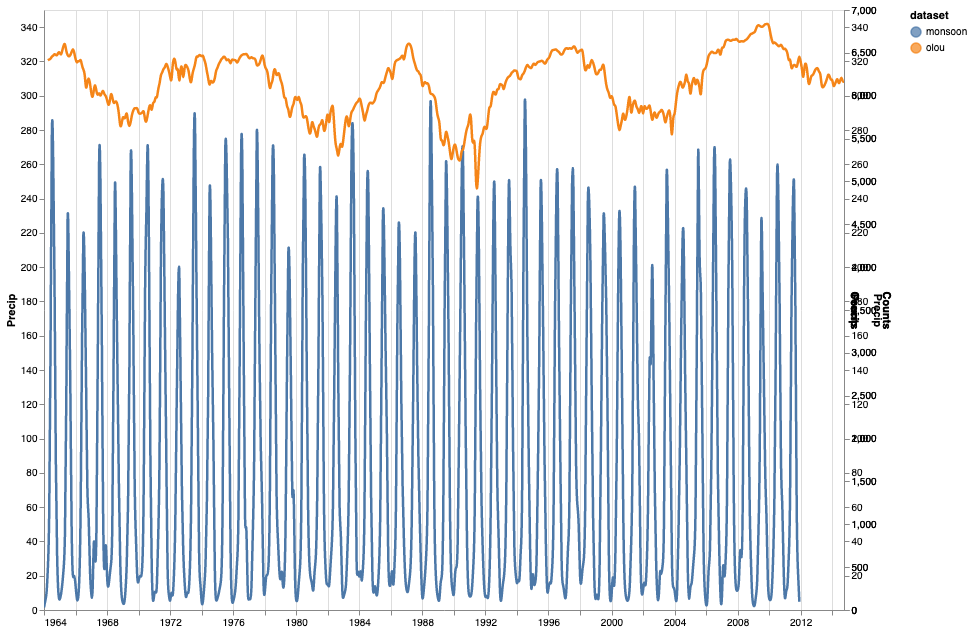

In [328]:
alt.layer(
    line_chart_monsoon, line_chart_olou, points_monsoon, points_olou,
    selectors_monsoon, selectors_olou, rules, text_monsoon, text_olou
).properties(
    width=800, height=600
).resolve_scale(x='shared', y='independent')

,Date,Precip,date_str,year,month,quarter,dataset,Counts
Date,,,,,,,,
1964-01-01,1964-01-01,1.4,1964-01-01,1964,1,1.0,monsoon,NaN
1964-02-01,1964-02-01,5.7,1964-02-01,1964,2,1.0,monsoon,NaN
1964-03-01,1964-03-01,8.3,1964-03-01,1964,3,1.0,monsoon,NaN
1964-04-01,1964-04-01,24.8,1964-04-01,1964,4,2.0,monsoon,NaN
1964-05-01,1964-05-01,43.7,1964-05-01,1964,5,2.0,monsoon,NaN


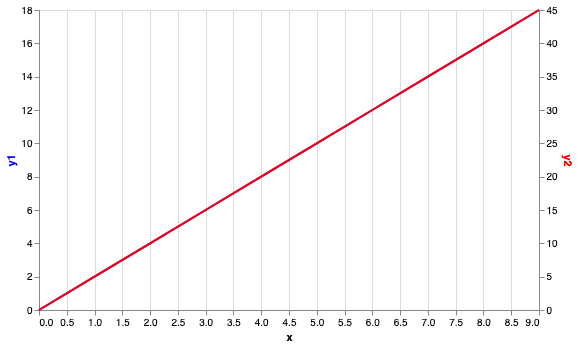

In [239]:
# THIS IS A WORKING EXAMPLE FROM CHAT

import altair as alt
import pandas as pd

# Sample data
data = pd.DataFrame({
    'x': range(10),
    'y1': [i * 2 for i in range(10)],  # First line data
    'y2': [i * 5 for i in range(10)]   # Second line data
})

# Base chart
base_chart = alt.Chart(data).encode(
    x='x'
).properties(
    width=500,
    height=300
)

# Chart for the first line with its own y-axis
chart1 = base_chart.mark_line(color='blue').encode(
    y=alt.Y('y1', axis=alt.Axis(titleColor='blue')),  # This specifies the first line with a blue axis
)

# Chart for the second line with a different y-axis
chart2 = base_chart.mark_line(color='red').encode(
    y=alt.Y('y2', axis=alt.Axis(titleColor='red')),  # This specifies the second line with a red axis
)

# Layering the charts and specifying the right y-axis for the second chart
combined_chart = alt.layer(
    chart1,
    chart2.encode(y=alt.Y('y2', axis=alt.Axis(titleColor='red'), scale=alt.Scale(zero=False)))
).resolve_scale(y='independent')

combined_chart

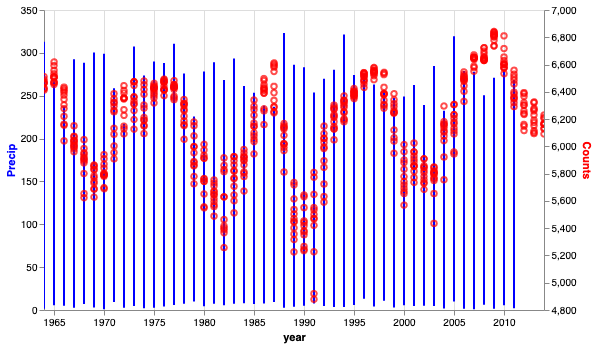

In [342]:
# Zoom and pan.
select = alt.selection_interval(
    bind="scales",
    encodings=["x"]
)

# Base chart
base_chart = alt.Chart(dataset).encode(
    x=alt.X('year:T')
).properties(
    width=500,
    height=300
)

monsoon = base_chart.mark_line(color='blue').encode(
    alt.Y(
        'Precip:Q',
        axis=alt.Axis(titleColor='blue')
    )
).add_params(
    select
)

olou = base_chart.mark_point(color='red').encode(
    y=alt.Y(
        'Counts:Q',
        axis=alt.Axis(titleColor='red'))
).add_params(
    select
)

combined_chart = alt.layer(
    monsoon,
    olou.encode(
        y=alt.Y(
            'Counts:Q',
            axis=alt.Axis(titleColor='red'),
            scale=alt.Scale(zero=False)
        )
    )
).resolve_scale(
    x='shared',
    y='independent'
)

combined_chart

In [206]:
dataset.head()

,Date,Precip,date_str,year,month,quarter,dataset,Counts
Date,,,,,,,,
1964-01-01,1964-01-01,1.4,1964-01-01,1964,1,1.0,monsoon,NaN
1964-02-01,1964-02-01,5.7,1964-02-01,1964,2,1.0,monsoon,NaN
1964-03-01,1964-03-01,8.3,1964-03-01,1964,3,1.0,monsoon,NaN
1964-04-01,1964-04-01,24.8,1964-04-01,1964,4,2.0,monsoon,NaN
1964-05-01,1964-05-01,43.7,1964-05-01,1964,5,2.0,monsoon,NaN
